# Running up that hill - An Empirical Data Analysis about my Running Habits and lack thereof
<p>In a former live, I have been an avid runner and cyclist until I started learning how to code. I started my running journey in 2010, also tried some cycling and other sports and fell off the waggon about 2018. I have been using the popular running tracker app <a href="https://runkeeper.com/">Runkeeper</a> for years, so let's see how much data the app collected over the years.
<p><img src="runner.jpg" alt="Runner" title="Explore world, explore your data!"></p>

## 1. Obtain and review raw data
<p>In this notebook I will import the data, clean it and finally analyze and visualize clean time-series data.</p>
<p>The app exported 12 years of training data, from 2010 till 2022. The data is a CSV file, each row representing a single training activity.</p>


In [233]:
# Import pandas
import pandas as pd

# Import the dataset from CSV file
runkeeper_file = 'datasets/cardioActivities.csv'

# Create DataFrame with parse_dates and index_col parameters 
df = pd.read_csv(runkeeper_file, parse_dates=True, sep=";", index_col='Date')

# First look at exported data: select sample of 3 random rows 
display(df.sample(3))

# Print DataFrame summary
print(df.info())

,Activity Id,Type,Route Name,Distance (km),Duration,Average Pace,Average Speed (km/h),Calories Burned,Climb (m),Average Heart Rate (bpm),Friend's Tagged,Notes,GPX File
Date,,,,,,,,,,,,,
2012-09-17 01:56:00,7488ba84-16d9-4cfa-8978-dcbde1305b0f,Running,NaN,3.80,31:42:00,08:20,7.20,237.0,31,149.0,NaN,NaN,2012-09-17-015608.gpx
2016-01-23 12:33:00,fb142c36-7bd5-4a03-b9d0-2ef356accd72,Running,NaN,2.00,10:00,05:00,12.00,148.0,0,147.0,NaN,NaN,NaN
2016-04-13 10:08:00,4b46c5fa-a7e1-4dbf-af16-b7acb1a6dfd0,Cycling,NaN,75.35,08:22:40,06:40,8.99,3109.0,743,NaN,NaN,NaN,2016-04-13-100839.gpx


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 871 entries, 2019-08-27 19:00:00 to 2017-03-22 09:04:00
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Activity Id               871 non-null    object 
 1   Type                      871 non-null    object 
 2   Route Name                11 non-null     object 
 3   Distance (km)             871 non-null    float64
 4   Duration                  871 non-null    object 
 5   Average Pace              849 non-null    object 
 6   Average Speed (km/h)      849 non-null    float64
 7   Calories Burned           871 non-null    float64
 8   Climb (m)                 871 non-null    int64  
 9   Average Heart Rate (bpm)  595 non-null    float64
 10  Friend's Tagged           44 non-null     object 
 11  Notes                     63 non-null     object 
 12  GPX File                  783 non-null    object 
dtypes: float64(4), int64(1), obj

## 2. Data cleaning
<p>The column names are informative and we don't need to rename any columns.</p>
<p>But the <code>info()</code> tells us, that there are missing values. Also, I need to remove all data that is not helpful for finding insights. The next steps will be:</p>
<ul>
<li>Count all activities.</li>
<li>Remove columns that are not useful for the analysis.</li>
<li>Filter out all activities that are not useful.</li>
<li>Count missing values.</li>
</ul>

In [234]:
print(df['Type'].value_counts())

Running               595
Cycling               233
Walking                18
Strength Training      13
Dance                   2
Meditation              2
Snowboarding            1
Core Strengthening      1
Sports                  1
Skating                 1
Swimming                1
Other                   1
Yoga                    1
Boxing / MMA            1
Name: Type, dtype: int64


<p>Let's add another step to filter out all the activities that I tried once or twice and gave up:</p>
<ul>
<li>Count all activities that I did at least three times (so that I can find the relevant activities).</li></ul>

In [235]:
print(df['Type'].value_counts().loc[lambda x : x>=3])

Running              595
Cycling              233
Walking               18
Strength Training     13
Name: Type, dtype: int64


I'm a visual guy, so let's plot that to get better insights.

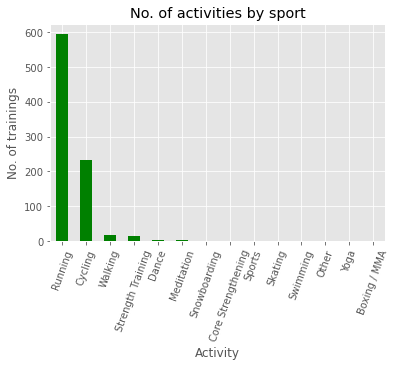

In [236]:
from matplotlib import pyplot as plt 

plt.style.use('ggplot')
df['Type'].value_counts().plot(kind='bar', xlabel="Activity", ylabel="No. of trainings", color="green", rot=70)
plt.title('No. of activities by sport')
plt.show()

<p>It looks like we should focus on Running and Cycling activities. Let's remove all the other rows and columns and check if the Filtering went well by counting all <code>Types</code> that are left.</p>

In [237]:
# Define list of columns to be deleted
cols_to_drop = ['Friend\'s Tagged','Route Name','GPX File','Activity Id','Calories Burned', 'Notes']

# Delete unnecessary columns
df = df.drop(cols_to_drop, axis="columns")

# Drop all other Types apart from Running and Cycling
df = df[df['Type'].isin(['Running', 'Cycling'])]
df = df.sort_values('Date')

# Check if Filtering worked out fine
display(df['Type'].value_counts())

# Count missing values for each column
display(df.isnull().sum())

Running    595
Cycling    233
Name: Type, dtype: int64

Type                          0
Distance (km)                 0
Duration                      0
Average Pace                  0
Average Speed (km/h)          0
Climb (m)                     0
Average Heart Rate (bpm)    233
dtype: int64

There are no missing values apart from 233 values in the <code>Average Heart Rate (bpm)</code> columns. Those are the cycling activities as I did not wear a heart monitor while biking. Let's ignore that.

In the next step I will divide the DataFrame into two separate DataFrames for Running and Cycling activities.

In [238]:
# Split whole DataFrame into several, specific for different activities
df_run = df[df['Type'] == 'Running'].copy()
df_cycle = df[df['Type'] == 'Cycling'].copy()

## 3. Plot running data
<p>Most of the activities in my data were running. For now, let's focus on plotting the running metrics.</p>
<p>A good first visualization is a figure with four subplots, one for each running metric (each numerical column). The x-axis, <code>Date</code>, is shared among all subplots.</p>

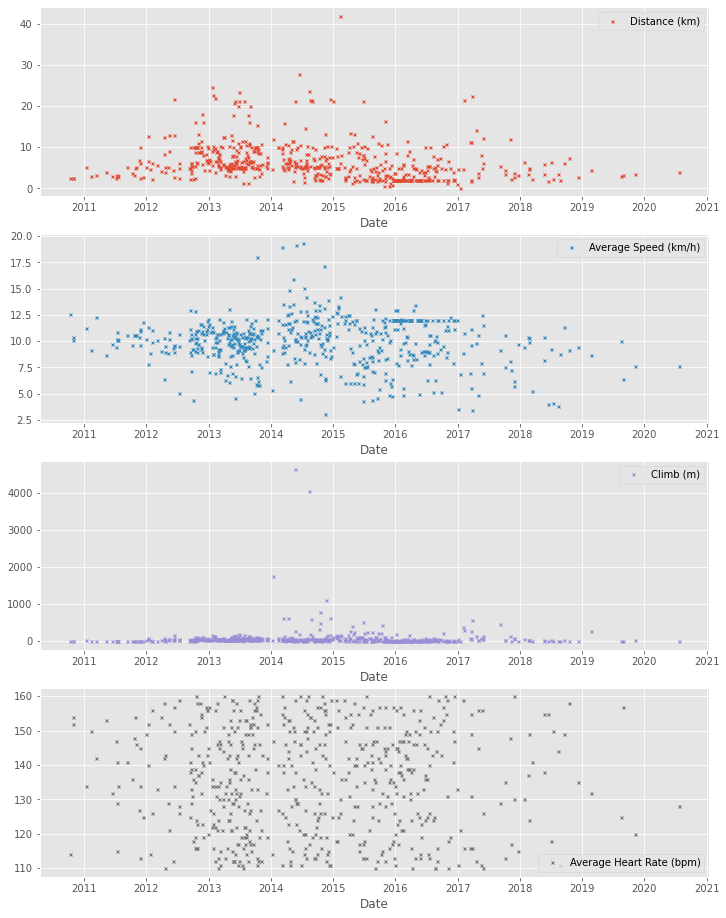

In [239]:
# Import matplotlib, set style and ignore warning
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')


# Create, plot and customize in one step
df_run.plot(subplots=True,
                        sharex=False,
                        figsize=(12,16),
                        linestyle='none',
                        marker='x',
                        markersize=3,
                        )

# Show plot
plt.show()

## 4. Running statistics

<p>In the last 4 plots I could see the <code>Distance</code> and <code>Average Speed</code>, both will be analyzed further, along with the <code>Climb</code> and <code>Average Heart Rate</code> which don't give useful insights. Living in the flatlands of Berlin it is not surprising that there is just very little variation in the <code>Climb</code> data. Also the <code>Average Heart Rate</code> is all over the place, might be corrupt data or a misaligned Heart Rate monitor. Both won't give me useful insights.</p>
<p>With the other columns <code>Distance</code> and <code>Average Speed</code> we can answer the following questions:</p>
<ul>
<li>What is my average distance?</li>
<li>How fast did I run on average?</li>
<li>How often did I train?</li>
</ul>


In [240]:
# Prepare running data for the years 2010 till 2021
runs_subset = df_run.loc["2010":"2021"]

# Calculate annual statistics
print('How my average run looks:')
display(runs_subset.resample('A').mean()) # resample averages the distance into a certain time frame, here 'A' is for year

# Calculate weekly statistics
print('Weekly averages:')
display(runs_subset.resample('W').mean().mean())

# Mean weekly counts
weekly_counts_average = runs_subset['Distance (km)'].resample('W').count().mean()
print('How many trainings per week I had on average:', weekly_counts_average)

How my average run looks:


,Distance (km),Average Speed (km/h),Climb (m),Average Heart Rate (bpm)
Date,,,,
2010-12-31,2.503333,11.050000,3.666667,140.000000
2011-12-31,4.234762,10.398571,10.761905,137.857143
2012-12-31,7.874308,9.949231,54.584615,138.215385
2013-12-31,8.099737,9.694211,66.184211,133.750000
2014-12-31,7.487179,10.904786,182.435897,136.273504
2015-12-31,5.572245,9.608061,80.030612,135.744898
2016-12-31,3.774421,10.316000,27.126316,137.063158
2017-12-31,7.037917,8.142500,133.041667,130.708333
2018-12-31,4.216000,8.267333,23.733333,139.600000


Weekly averages:


Distance (km)                 6.303019
Average Speed (km/h)          9.802666
Climb (m)                    79.878080
Average Heart Rate (bpm)    135.667704
dtype: float64

How many trainings per week I had on average: 1.162109375


We can see, that I started my training slowly in 2010 with an average of 2,5km per week, steadily improving until peaking in 2013 with 8 km and then declining hard until 2020 with 3,8km. Speedwise I always had a steady 9,5-11km/h speed until 2017. I only trained 1,16 times per week, which feels weird because I remember hitting the road much more often. How blurry your memory gets, when you get older :/

## 5. Visualization with averages
<p>Let's plot the long term averages of my distance run with their raw data to visually compare the averages to each training session. Again, we'll use the data from 2010 through 2020.</p>

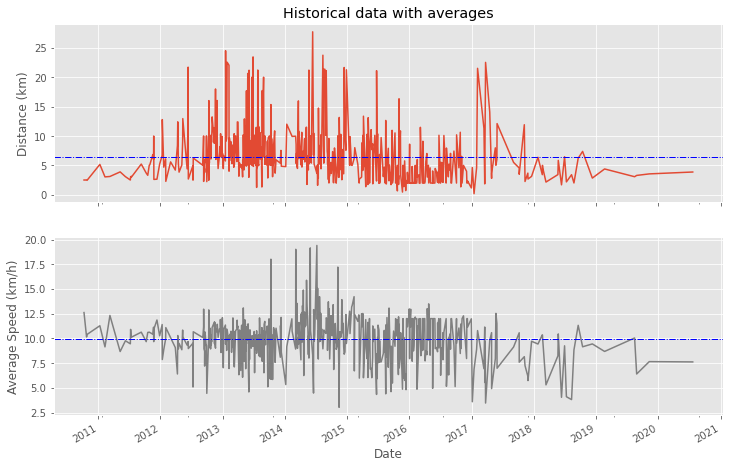

In [296]:
# Prepare data
runs_subset = df_run.loc['2010':'2020']
runs_distance = runs_subset['Distance (km)']
runs_distance = runs_distance[runs_distance < 40] # This filters out all runs with a distance above 40 km as I saw there was one entry with 42 km which is an error, I have never been running that far.
runs_speed = runs_subset['Average Speed (km/h)']

# Create plot
fig, (ax1,ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

# Plot and customize first subplot
runs_distance.plot(ax=ax1)
ax1.set(ylabel='Distance (km)', title='Historical data with averages')
ax1.axhline(runs_distance.mean(), color='blue', linewidth=1, linestyle='-.')

# Plot and customize second subplot
runs_speed.plot(ax=ax2, color='gray')
ax2.set(xlabel='Date', ylabel='Average Speed (km/h)')
ax2.axhline(runs_speed.mean(), color='blue', linewidth=1, linestyle='-.')

# Show plot
plt.show()

## 6. Did I reach my goals?
<p>To motivate myself to run regularly, I set a target goal of running 1000 km per year. Let's visualize my annual running distance (km) from 2012 through 2018, my most active years, to see if I reached my goal each year. Only stars in the green region indicate success.</p>

In [292]:
runs_per_week = df_run['2012':'2019']['Distance (km)'].resample('A').count()/52 # This counts the average number of runs per week in each year
runs_per_week

Date
2012-12-31    1.250000
2013-12-31    2.923077
2014-12-31    2.250000
2015-12-31    1.884615
2016-12-31    1.826923
2017-12-31    0.461538
2018-12-31    0.288462
2019-12-31    0.076923
Freq: A-DEC, Name: Distance (km), dtype: float64

In [270]:
df_run_dist_annual = df_run['2012':'2019']['Distance (km)'].resample('A').sum() # This sums up the distance per year
df_run_dist_annual

Date
2012-12-31     511.83
2013-12-31    1231.16
2014-12-31     876.00
2015-12-31     546.08
2016-12-31     358.57
2017-12-31     168.91
2018-12-31      63.24
2019-12-31      14.34
Freq: A-DEC, Name: Distance (km), dtype: float64

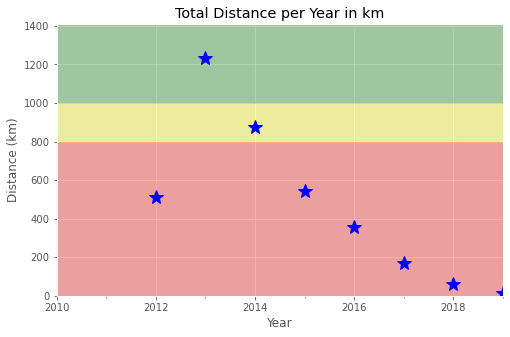

In [272]:
# Prepare data
df_run_dist_annual = df_run['2012':'2019']['Distance (km)'].resample('A').sum()

# Create plot
fig = plt.figure(figsize=(8,5))

# Plot and customize
ax = df_run_dist_annual.plot(marker='*', markersize=14, linewidth=0, color='blue')
ax.set(ylim=[0, 1410], 
       xlim=['2010','2019'],
       ylabel='Distance (km)',
       xlabel='Year',
       title='Total Distance per Year in km')

ax.axhspan(1000, 1410, color='green', alpha=0.3)
ax.axhspan(800, 1000, color='yellow', alpha=0.3)
ax.axhspan(0,800, color='red', alpha=0.3)

# Show plot
plt.show()

## 7. Final conclusion
<p>As the data tells, I really had my athletical peak in 2013 with the biggest average distance of 8 km per run and most runs per year (almost every second day!). Also I won some medals that year!</p>